# Preparación
Se monta el sistema de archivos de google drive.


In [35]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-01-07 12:14:18.817843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'/device:GPU:0'

2022-01-07 12:14:18.818382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 12:14:18.818699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 12:14:18.819097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 12:14:18.819437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 12:14:18.819718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 1

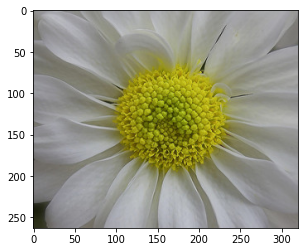

In [36]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [37]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# Modelo

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization

In [39]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights=None, include_top=True, classes = 5)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

# Visualización del modelo

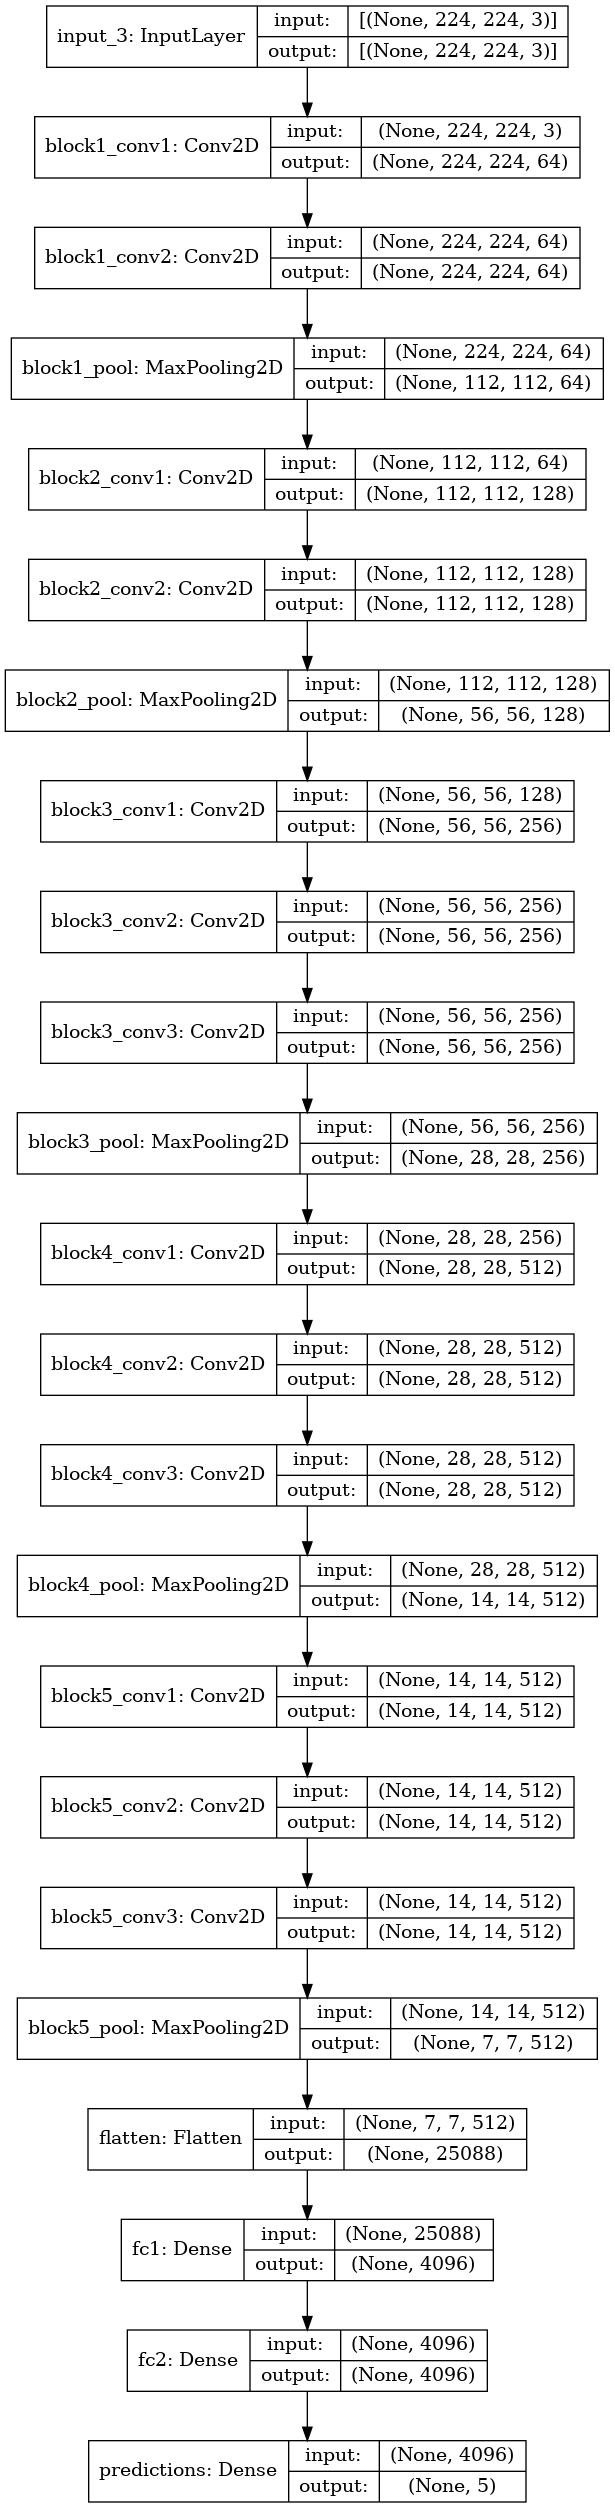

In [40]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [41]:
from keras.callbacks import EarlyStopping

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
108/108 [==============================] - 37s 295ms/step - loss: 1.4930 - accuracy: 0.3280 - val_loss: 1.3796 - val_accuracy: 0.3975
Epoch 2/200
108/108 [==============================] - 25s 232ms/step - loss: 1.3164 - accuracy: 0.4418 - val_loss: 1.2106 - val_accuracy: 0.4959
Epoch 3/200
108/108 [==============================] - 25s 231ms/step - loss: 1.2505 - accuracy: 0.4676 - val_loss: 1.1146 - val_accuracy: 0.5539
Epoch 4/200
108/108 [==============================] - 25s 231ms/step - loss: 1.1139 - accuracy: 0.5536 - val_loss: 1.1224 - val_accuracy: 0.5319
Epoch 5/200
108/108 [==============================] - 25s 231ms/step - loss: 1.0679 - accuracy: 0.5724 - val_loss: 1.1632 - val_accuracy: 0.5353
Epoch 6/200
108/108 [==============================] - 25s 231ms/step - loss: 1.0191 - accuracy: 0.5921 - val_loss: 1.0552 - val_accuracy: 0.5991
Epoch 7/200
108/108 [==============================] - 25s 230ms/step - loss: 0.9909 - accuracy: 0.6106 - val_loss: 1.0551 -

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

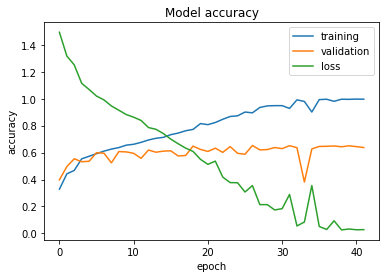

In [42]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.5474    0.6148    0.5792       122
           1     0.7393    0.7178    0.7284       241
           2     0.4967    0.5952    0.5415       126
           3     0.7667    0.7188    0.7419       160
           4     0.6545    0.5841    0.6173       214

    accuracy                         0.6524       863
   macro avg     0.6409    0.6461    0.6417       863
weighted avg     0.6608    0.6524    0.6550       863



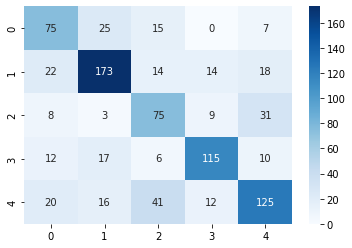

In [43]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [44]:
img = keras.preprocessing.image.load_img(
    '../input/flowers-recognition/flowers/daisy/10172636503_21bededa75_n.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1
